# Wuzzuf Job Market Analysis - Salary Insights Analysis

This notebook analyzes salary trends and compensation patterns in the Wuzzuf job market data.

## Business Question:
**What are the salary trends and compensation patterns across different roles, industries, and experience levels?**

This analysis examines salary ranges, average compensation by various dimensions, and provides insights into market rates and compensation trends across the job market.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os
from pathlib import Path

# Add sql directory to path for database utilities
sys.path.append('../sql')
from database_setup import DatabaseManager

# Configure display and warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create charts directory if it doesn't exist
charts_dir = Path('../assets/charts')
charts_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")
print(f"Charts will be saved to: {charts_dir.absolute()}")

Libraries imported successfully
Charts will be saved to: c:\Users\hp\Downloads\wuzuf-analysis\notebooks\..\assets\charts


In [2]:
# Initialize database connection
print("Connecting to PostgreSQL database...")

try:
    db_manager = DatabaseManager()
    engine = db_manager.get_engine()
    
    # Test connection
    status = db_manager.test_connection()
    print(f"✅ Connected to database: {status['database']}")
    print(f"📊 Tables available: {status['table_count']}")
    
except Exception as e:
    print(f"❌ Database connection failed: {e}")
    print("Please ensure PostgreSQL is running and database is set up correctly")
    raise

2025-08-14 23:10:52,488 - INFO - Database connection established successfully


Connecting to PostgreSQL database...
✅ Connected to database: wuzzuf
📊 Tables available: 6


## Data Coverage Analysis

First, let's examine what percentage of job postings have salary data available.

In [3]:
# Data coverage report - percentage of records with salary data
coverage_query = """
SELECT 
    COUNT(*) as total_jobs,
    COUNT(CASE WHEN salary_min IS NOT NULL AND salary_max IS NOT NULL THEN 1 END) as jobs_with_salary,
    ROUND(
        COUNT(CASE WHEN salary_min IS NOT NULL AND salary_max IS NOT NULL THEN 1 END) * 100.0 / COUNT(*), 
        2
    ) as salary_coverage_percentage
FROM jobs;
"""

print("📊 Data Coverage Analysis")
print("=" * 50)

coverage_df = pd.read_sql(coverage_query, engine)
print("📈 Salary Data Coverage:")
print(coverage_df.to_string(index=False))

# Store coverage stats for later use
total_jobs = coverage_df['total_jobs'].iloc[0]
jobs_with_salary = coverage_df['jobs_with_salary'].iloc[0]
coverage_percentage = coverage_df['salary_coverage_percentage'].iloc[0]

print(f"\n💡 Key Insight: {coverage_percentage}% of job postings ({jobs_with_salary:,} out of {total_jobs:,}) include salary information.")

📊 Data Coverage Analysis
📈 Salary Data Coverage:
 total_jobs  jobs_with_salary  salary_coverage_percentage
      25114              1496                        5.96

💡 Key Insight: 5.96% of job postings (1,496 out of 25,114) include salary information.


## Salary Analysis by Role

Analyzing average minimum and maximum salaries by job role for positions with salary data.

In [4]:
# SQL query for average min/max salaries by role
salary_by_role_query = """
SELECT 
    job_title,
    COUNT(*) as job_count,
    ROUND(AVG(salary_min), 0) as avg_min_salary,
    ROUND(AVG(salary_max), 0) as avg_max_salary,
    ROUND(AVG((salary_min + salary_max) / 2.0), 0) as avg_mid_salary,
    ROUND(AVG(salary_max - salary_min), 0) as avg_salary_range
FROM jobs 
WHERE salary_min IS NOT NULL 
    AND salary_max IS NOT NULL
    AND job_title IS NOT NULL 
    AND job_title != ''
GROUP BY job_title 
HAVING COUNT(*) >= 10  -- Only roles with at least 10 salary data points
ORDER BY avg_mid_salary DESC
LIMIT 10;
"""

print("\n🔍 Analysis: Average Salaries by Job Role")
print("=" * 50)

salary_by_role_df = pd.read_sql(salary_by_role_query, engine)
print("💰 Top Paying Roles (with salary data):")
print(salary_by_role_df.to_string(index=False))

# Store for visualization
role_salary_summary = salary_by_role_df.head(10)


🔍 Analysis: Average Salaries by Job Role
💰 Top Paying Roles (with salary data):
                    job_title  job_count  avg_min_salary  avg_max_salary  avg_mid_salary  avg_salary_range
    machine learning engineer         33        147576.0        192848.0        170212.0           45273.0
               data scientist         90        126144.0        169156.0        147650.0           43011.0
              product manager         36        116389.0        156806.0        136597.0           40417.0
            software engineer        580        110624.0        158348.0        134486.0           47724.0
                data engineer        177        111797.0        149458.0        130627.0           37661.0
                    developer         28        103000.0        135107.0        119054.0           32107.0
software development engineer         17         87941.0        137588.0        112765.0           49647.0
           software developer         46         75522.0       

## Salary Analysis by Industry

Examining compensation patterns across different industries.

In [5]:
# SQL query for average min/max salaries by industry
salary_by_industry_query = """
SELECT 
    c.industry,
    COUNT(*) as job_count,
    ROUND(AVG(j.salary_min), 0) as avg_min_salary,
    ROUND(AVG(j.salary_max), 0) as avg_max_salary,
    ROUND(AVG((j.salary_min + j.salary_max) / 2.0), 0) as avg_mid_salary,
    ROUND(AVG(j.salary_max - j.salary_min), 0) as avg_salary_range
FROM jobs j
JOIN companies c ON j.company_id = c.company_id
WHERE j.salary_min IS NOT NULL 
    AND j.salary_max IS NOT NULL
    AND c.industry IS NOT NULL 
    AND c.industry != ''
GROUP BY c.industry 
HAVING COUNT(*) >= 5  -- Only industries with at least 5 salary data points
ORDER BY avg_mid_salary DESC
LIMIT 10;
"""

print("\n" + "-" * 50)
print("🏢 Average Salaries by Industry:")

salary_by_industry_df = pd.read_sql(salary_by_industry_query, engine)
print(salary_by_industry_df.to_string(index=False))


--------------------------------------------------
🏢 Average Salaries by Industry:
                         industry  job_count  avg_min_salary  avg_max_salary  avg_mid_salary  avg_salary_range
                       automotive          7        134000.0        188714.0        161357.0           54714.0
            management consulting         51        117843.0        160294.0        139069.0           42451.0
                         internet        125        107192.0        164392.0        135792.0           57200.0
            staffing & recruiting        456        117605.0        152292.0        134948.0           34686.0
                computer software        165        105691.0        153945.0        129818.0           48255.0
             consumer electronics          5         91000.0        157800.0        124400.0           66800.0
               financial services         68         94397.0        154191.0        124294.0           59794.0
                       publi

## Salary Analysis by Experience Level

Comparing compensation across different experience levels.

In [6]:
# SQL query for average min/max salaries by experience level
salary_by_experience_query = """
SELECT 
    experience_level,
    COUNT(*) as job_count,
    ROUND(AVG(salary_min), 0) as avg_min_salary,
    ROUND(AVG(salary_max), 0) as avg_max_salary,
    ROUND(AVG((salary_min + salary_max) / 2.0), 0) as avg_mid_salary,
    ROUND(AVG(salary_max - salary_min), 0) as avg_salary_range
FROM jobs 
WHERE salary_min IS NOT NULL 
    AND salary_max IS NOT NULL
    AND experience_level IS NOT NULL 
    AND experience_level != ''
GROUP BY experience_level 
ORDER BY 
    CASE experience_level 
        WHEN 'Entry' THEN 1 
        WHEN 'Mid' THEN 2 
        WHEN 'Senior' THEN 3 
        ELSE 4 
    END;
"""

print("\n" + "-" * 50)
print("📈 Average Salaries by Experience Level:")

salary_by_experience_df = pd.read_sql(salary_by_experience_query, engine)
print(salary_by_experience_df.to_string(index=False))


--------------------------------------------------
📈 Average Salaries by Experience Level:
experience_level  job_count  avg_min_salary  avg_max_salary  avg_mid_salary  avg_salary_range
           Entry        288         80698.0        122424.0        101561.0           41726.0
             Mid        780         98958.0        138395.0        118676.0           39437.0
          Senior        428        112722.0        152054.0        132388.0           39332.0


## Statistical Summary

Creating a comprehensive statistical summary of salary data for the final analysis table.

In [7]:
# Create comprehensive salary analysis summary (max 10 rows as per requirements)
print("\n" + "=" * 50)
print("📊 Comprehensive Salary Analysis Summary")
print("=" * 50)

# Combine top insights from role, industry, and experience analysis
salary_summary_data = []

# Add top 3 paying roles
for idx, row in role_salary_summary.head(3).iterrows():
    salary_summary_data.append({
        'category': 'Role',
        'name': row['job_title'],
        'job_count': row['job_count'],
        'avg_min_salary': row['avg_min_salary'],
        'avg_max_salary': row['avg_max_salary'],
        'avg_mid_salary': row['avg_mid_salary']
    })

# Add top 3 paying industries
for idx, row in salary_by_industry_df.head(3).iterrows():
    salary_summary_data.append({
        'category': 'Industry',
        'name': row['industry'],
        'job_count': row['job_count'],
        'avg_min_salary': row['avg_min_salary'],
        'avg_max_salary': row['avg_max_salary'],
        'avg_mid_salary': row['avg_mid_salary']
    })

# Add all experience levels
for idx, row in salary_by_experience_df.iterrows():
    salary_summary_data.append({
        'category': 'Experience',
        'name': row['experience_level'],
        'job_count': row['job_count'],
        'avg_min_salary': row['avg_min_salary'],
        'avg_max_salary': row['avg_max_salary'],
        'avg_mid_salary': row['avg_mid_salary']
    })

# Create final summary DataFrame (limit to 10 rows)
salary_analysis_summary = pd.DataFrame(salary_summary_data).head(10)

print("💰 Final Salary Analysis Table:")
print(salary_analysis_summary.to_string(index=False))


📊 Comprehensive Salary Analysis Summary
💰 Final Salary Analysis Table:
  category                      name  job_count  avg_min_salary  avg_max_salary  avg_mid_salary
      Role machine learning engineer         33        147576.0        192848.0        170212.0
      Role            data scientist         90        126144.0        169156.0        147650.0
      Role           product manager         36        116389.0        156806.0        136597.0
  Industry                automotive          7        134000.0        188714.0        161357.0
  Industry     management consulting         51        117843.0        160294.0        139069.0
  Industry                  internet        125        107192.0        164392.0        135792.0
Experience                     Entry        288         80698.0        122424.0        101561.0
Experience                       Mid        780         98958.0        138395.0        118676.0
Experience                    Senior        428        112722.0 

## Visualization: Salary Insights Chart

Creating a bar chart visualization showing average salaries across different dimensions.


📈 Creating Salary Insights Visualization...


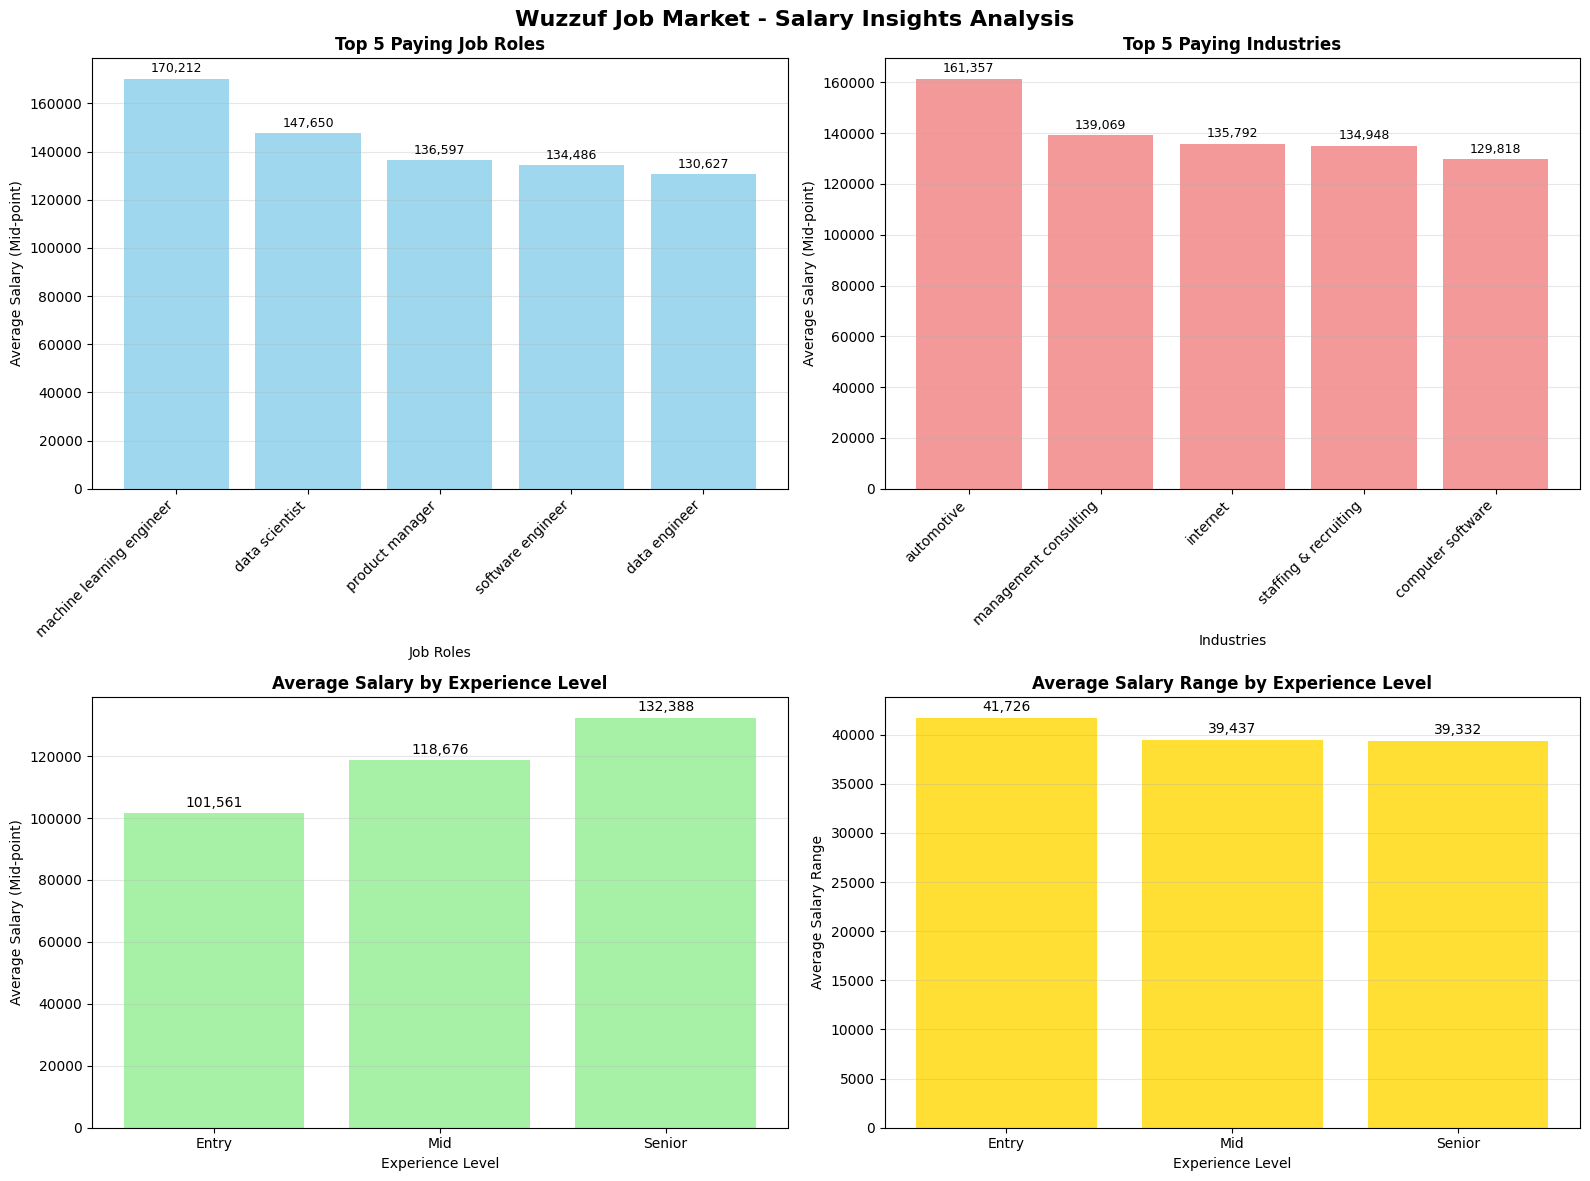

✅ Chart saved to: ..\assets\charts\salary_insights.png


In [8]:
# Create salary insights visualization
print("\n" + "=" * 50)
print("📈 Creating Salary Insights Visualization...")

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Wuzzuf Job Market - Salary Insights Analysis', fontsize=16, fontweight='bold')

# 1. Top Paying Roles
top_roles = role_salary_summary.head(5)
bars1 = ax1.bar(range(len(top_roles)), top_roles['avg_mid_salary'], 
                color='skyblue', alpha=0.8)
ax1.set_title('Top 5 Paying Job Roles', fontweight='bold')
ax1.set_xlabel('Job Roles')
ax1.set_ylabel('Average Salary (Mid-point)')
ax1.set_xticks(range(len(top_roles)))
ax1.set_xticklabels(top_roles['job_title'], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# 2. Top Paying Industries
top_industries = salary_by_industry_df.head(5)
bars2 = ax2.bar(range(len(top_industries)), top_industries['avg_mid_salary'], 
                color='lightcoral', alpha=0.8)
ax2.set_title('Top 5 Paying Industries', fontweight='bold')
ax2.set_xlabel('Industries')
ax2.set_ylabel('Average Salary (Mid-point)')
ax2.set_xticks(range(len(top_industries)))
ax2.set_xticklabels(top_industries['industry'], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# 3. Salary by Experience Level
bars3 = ax3.bar(salary_by_experience_df['experience_level'], 
                salary_by_experience_df['avg_mid_salary'], 
                color='lightgreen', alpha=0.8)
ax3.set_title('Average Salary by Experience Level', fontweight='bold')
ax3.set_xlabel('Experience Level')
ax3.set_ylabel('Average Salary (Mid-point)')
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# 4. Salary Range Analysis
bars4 = ax4.bar(salary_by_experience_df['experience_level'], 
                salary_by_experience_df['avg_salary_range'], 
                color='gold', alpha=0.8)
ax4.set_title('Average Salary Range by Experience Level', fontweight='bold')
ax4.set_xlabel('Experience Level')
ax4.set_ylabel('Average Salary Range')
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# Adjust layout and save
plt.tight_layout()
chart_path = charts_dir / 'salary_insights.png'
plt.savefig(chart_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Chart saved to: {chart_path}")

## Business Insights

Key findings and business insights from the salary analysis.

In [9]:
# Generate business insights
print("\n" + "=" * 50)
print("💡 Business Insights - Salary Trends and Market Rates")
print("=" * 50)

# Calculate key metrics for insights
highest_paying_role = role_salary_summary.iloc[0]
highest_paying_industry = salary_by_industry_df.iloc[0]
senior_vs_entry_ratio = (salary_by_experience_df[salary_by_experience_df['experience_level'] == 'Senior']['avg_mid_salary'].iloc[0] / 
                        salary_by_experience_df[salary_by_experience_df['experience_level'] == 'Entry']['avg_mid_salary'].iloc[0])

insights = [
    f"📊 Data Coverage: Only {coverage_percentage}% of job postings include salary information, indicating limited salary transparency in the market.",
    
    f"💰 Top Paying Role: {highest_paying_role['job_title']} offers the highest average compensation at {highest_paying_role['avg_mid_salary']:,.0f}, with {highest_paying_role['job_count']} positions available.",
    
    f"🏢 Industry Leader: {highest_paying_industry['industry']} industry provides the highest average salaries at {highest_paying_industry['avg_mid_salary']:,.0f}, demonstrating strong market demand and compensation levels.",
    
    f"📈 Experience Premium: Senior-level positions command {senior_vs_entry_ratio:.1f}x higher salaries than entry-level roles, highlighting the significant value of experience in the job market."
]

for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")
    print()

print("\n🎯 Strategic Recommendations:")
print("• Job seekers should focus on high-demand technical roles and industries with strong compensation packages")
print("• Companies should improve salary transparency to attract top talent in competitive markets")
print("• Career development investments show clear ROI through experience-based salary progression")


💡 Business Insights - Salary Trends and Market Rates
1. 📊 Data Coverage: Only 5.96% of job postings include salary information, indicating limited salary transparency in the market.

2. 💰 Top Paying Role: machine learning engineer offers the highest average compensation at 170,212, with 33 positions available.

3. 🏢 Industry Leader: automotive industry provides the highest average salaries at 161,357, demonstrating strong market demand and compensation levels.

4. 📈 Experience Premium: Senior-level positions command 1.3x higher salaries than entry-level roles, highlighting the significant value of experience in the job market.


🎯 Strategic Recommendations:
• Job seekers should focus on high-demand technical roles and industries with strong compensation packages
• Companies should improve salary transparency to attract top talent in competitive markets
• Career development investments show clear ROI through experience-based salary progression
